<a href="https://colab.research.google.com/github/HamzaNasiem/langgraph_projects/blob/main/chat_7_1_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph tavily-python wikipedia langchain_community langgraph-checkpoint-postgres langgraph_sdk

In [95]:
import os
from google.colab import userdata
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import WikipediaLoader
from langgraph.graph import MessagesState, START, StateGraph, END, add_messages
from langchain_core.messages import HumanMessage, SystemMessage,AnyMessage, RemoveMessage
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel
from langgraph.types import Command
from typing import Literal, Annotated
from psycopg_pool import ConnectionPool
from langgraph.checkpoint.postgres import PostgresSaver
from langchain_core.runnables import RunnableConfig
from langgraph_sdk import get_client

In [96]:
gemini_api_key = userdata.get('GEMINI_API_KEY')
DB_URI = userdata.get('DB_URL')
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "tool_summary_chatbot"

In [123]:
sys_msg = SystemMessage(
    content=(
        "You are a smart assistant with access to tools. Follow these rules carefully:\n\n"
        "### Tools Available:\n"
        "1. **web_search** - Use this to search the internet for real-time or web-based information. Examples:\n"
        "   - 'What is the current weather in Karachi?'\n"
        "   - 'Find the latest news about artificial intelligence.'\n\n"
        "2. **search_wikipedia** - Use this to fetch general knowledge from Wikipedia. Examples:\n"
        "   - 'Who is Albert Einstein?'\n"
        "   - 'Explain quantum physics.'\n\n"
        "### How to Decide:\n"
        "- If the user query needs factual or detailed answers from the web or Wikipedia, call the relevant tool.\n"
        "- For simple conversational or generic queries (like jokes or opinions), respond directly.\n\n"
        "### Examples of Behavior:\n"
        "- Query: 'What is the capital of France?' -> Call **search_wikipedia**.\n"
        "- Query: 'Tell me a joke.' -> Respond directly.\n"
        "- Query: 'What is the price of Bitcoin?' -> Call **web_search**.\n\n"
        "You MUST decide based on the query and provide a helpful, accurate response."
    )
)


In [124]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", max_retries=2, api_key=gemini_api_key)
tavily_tool = TavilySearchResults(max_results=2)

In [99]:
connection_kwargs = {"autocommit": True, "prepare_threshold": 0}
pool = ConnectionPool(conninfo=DB_URI, max_size=20, kwargs=connection_kwargs)
checkpointer = PostgresSaver(pool)
checkpointer.setup()


In [126]:
class State(MessagesState):
    summary: str

In [147]:
def web_search(query: str) -> str:
    """
    Tool Name: web_search

    Description:
        Performs a web search using the Tavily API to retrieve real-time or web-based information.
        This tool is ideal for queries that require the latest updates, current events, or dynamic information not found in static knowledge bases.

    When to Use:
        - Queries related to real-time information (e.g., "latest news about AI").
        - Questions about live or dynamic data (e.g., "current weather in Karachi").
        - General web searches for diverse topics (e.g., "top movies of 2025").

    Args:
        query (str): A string containing the search query from the user.

    Returns:
        str:
            - A formatted string containing the top search results, including URLs and summarized content.
            - Returns "No results found" if the search does not yield any results.

    Example:
        >>> web_search("latest technology news")
        '1. AI breakthroughs: https://example.com\n2. Quantum computing updates: https://example.org'
    """
    try:
        print(f"Web search invoked with query: {query}")
        results = tavily_tool.run(query)

        if not results:
            print("No results found from Tavily.")
            return "No results found."

        formatted_search_docs = "\n\n---\n\n".join(
            [
                f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
                for doc in results
            ]
        )

        return formatted_search_docs
    except Exception as e:
        print(f"Error during web search: {e}")
        return "An error occurred while processing your request."


In [148]:
def search_wikipedia(query: str) -> str:
    """
    Tool Name: search_wikipedia

    Description:
        Fetches summarized and structured content from Wikipedia based on the user's query.
        This tool is suitable for retrieving static, encyclopedic knowledge or in-depth explanations of topics.

    When to Use:
        - Queries seeking historical, scientific, or encyclopedic information (e.g., "Who is Albert Einstein?").
        - Questions about general knowledge topics (e.g., "Explain the causes of World War II").
        - Detailed explanations of theories or concepts (e.g., "What is quantum mechanics?").

    Args:
        query (str): A string containing the search query provided by the user.

    Returns:
        str:
            - A formatted string with summarized Wikipedia content, including metadata such as source links and page numbers.
            - Returns an empty string if no content is found.

    Example:
        >>> search_wikipedia("Theory of Relativity")
        '<Document source="https://en.wikipedia.org/wiki/Theory_of_relativity" page="1"/>\nThe theory of relativity, developed by Albert Einstein, revolutionized physics.\n</Document>'
    """
    search_docs = WikipediaLoader(query=query, load_max_docs=2).load()

    if not search_docs:
        print("No Wikipedia content found.")
        return ""

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    print(f"Wikipedia results: {formatted_search_docs}")
    return formatted_search_docs


In [149]:
tools = [web_search, search_wikipedia]
llm_with_tools = llm.bind_tools(tools)

In [150]:
def human_feedback(state: State):
    pass

In [151]:
def assistant(state: State, config: RunnableConfig):
    """
    Tool Node: assistant

    Description:
        Handles user messages and determines the next action:
        - Calls a tool (e.g., web search, Wikipedia search) if necessary.
        - Directly responds to the user when no tool is required.
        - Prepends a conversation summary to provide context for the LLM when applicable.

    When to Use:
        This node is the main decision-making function in the conversation flow.
        It ensures that user queries are appropriately handled, either by calling tools or providing direct responses.

    Args:
        state (MessagesState):
            - Tracks the entire conversation's state, including past messages and any saved summaries.
            - Used to retrieve current context for response generation.
        config (RunnableConfig):
            - Configuration options for the language model.
            - Includes runtime parameters, system messages, and tool integrations.

    Returns:
        dict: A dictionary containing updated messages:
            - {"messages": [...]} — Updated state of the conversation, including the LLM's response or tool outputs.

    Example Flow:
        1. User query: "What is the weather in Karachi today?"
        2. assistant function decides to call the web_search tool.
        3. Web search results are retrieved and added to the conversation as messages.
    """
    summary = state.get("summary", "")
    if summary:
        system_message = f"Summary of conversation earlier: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]
    response = llm_with_tools.invoke([sys_msg] + state["messages"], config)
    return {"messages": response}

In [152]:
def summarize_conversation(state: State):
    print(f"Messages before summarizing: {len(state['messages'])}")
    summary = state.get("summary", "")
    print(f"Existing summary: {summary}")

    # Clearer summarization prompt
    summary_message = (
        f"This is the conversation so far:\n\n{[msg.content for msg in state['messages']]}\n\n"
        "Please summarize it in 2-3 sentences for context."
    )

    # Send messages for summarization
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm_with_tools.invoke([sys_msg] + messages)

    # Debug the LLM response
    print(f"New summary: {response.content}")

    # Update the state with the new summary
    new_summary = response.content.strip()
    if new_summary:
        state["summary"] = new_summary

    # Truncate the message history
    retained_messages = state["messages"][-4:]  # Retain last 4 messages for context
    print(f"Messages after truncation: {len(retained_messages)}")
    return {"summary": new_summary, "messages": retained_messages}

In [153]:
def should_continue(state: State):
    """Return the next node to execute."""
    messages = state["messages"]
    print(f"Messages Length: {len(messages)}")  # Debugging
    if len(messages) > 6:
        return "summarize_conversation"
    return END


In [159]:
memory = MemorySaver()

builder: StateGraph = StateGraph(State)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("summarize_conversation", summarize_conversation)
# builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant",tools_condition)
builder.add_edge("tools", "assistant")
builder.add_conditional_edges("assistant",should_continue)
builder.add_edge("summarize_conversation", END)

react_graph: CompiledStateGraph = builder.compile(
    interrupt_before=["tools"],
    checkpointer=memory
    )


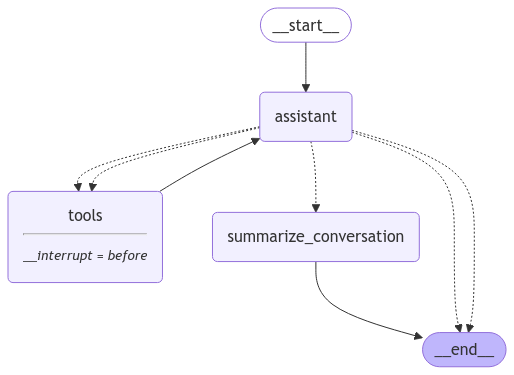

In [160]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [165]:
# Create a thread
config = {"configurable": {"thread_id": "2222"}}

# Start conversation
input_message = input("user query: ")
for event in react_graph.stream({"messages": [input_message]}, config,  stream_mode="values"):
  event['messages'][-1].pretty_print()



In [165]:
user_approval = input("Do you want to continue? (yes/no): ")

if user_approval.lower() == "yes":
    for event in react_graph.stream(None, config,  stream_mode="values"):
      event['messages'][-1].pretty_print()
else:
    print("Conversation stopped.")